<a href="https://colab.research.google.com/github/mfakhru/time-series/blob/main/time_series_AEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TIME SERIES: American Electric Power (AEP)**

Proyek membuat model untuk prediksi Time Series. Dataset yang digunakan berasal dari [Kaggle Hourly Energy Consumption.](https://www.kaggle.com/robikscube/hourly-energy-consumption)


Oleh:
> Muhammad Fakhrurrozi Sutisna



## Proses Persiapan

In [ ]:
# mengimpor library yang dibutuhkan

import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

## Persiapan Data

In [ ]:
# mengupload dataset

files = files.upload()

Saving AEP_hourly.zip to AEP_hourly.zip


In [ ]:
# unzip dataset dan menghapus file .zip

!unzip AEP_hourly.zip && rm AEP_hourly.zip
!ls

Archive:  AEP_hourly.zip
  inflating: AEP_hourly.csv          
AEP_hourly.csv	sample_data


In [ ]:
# memasukan dataset ke dalam dataframe

dataset = 'AEP_hourly.csv'

df = pd.read_csv(dataset)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
df = pd.read_csv(dataset, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
# memeriksa missing data

df.isnull().sum()

AEP_MW    0
dtype: int64

## Data Visualization

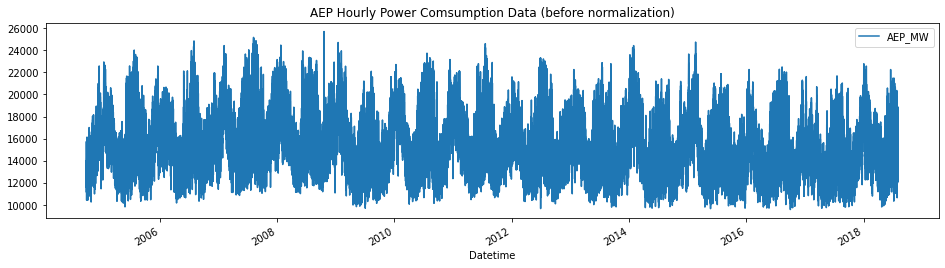

In [ ]:
# visualisasi data sebelum di normalisasi

df.plot(figsize=(16,4), legend=True)
plt.title('AEP Hourly Power Comsumption Data (before normalization)')
plt.show()

In [ ]:
# normalisasi data

def normalize_data(df):
  scaler = sklearn.preprocessing.MinMaxScaler()
  df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
  return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

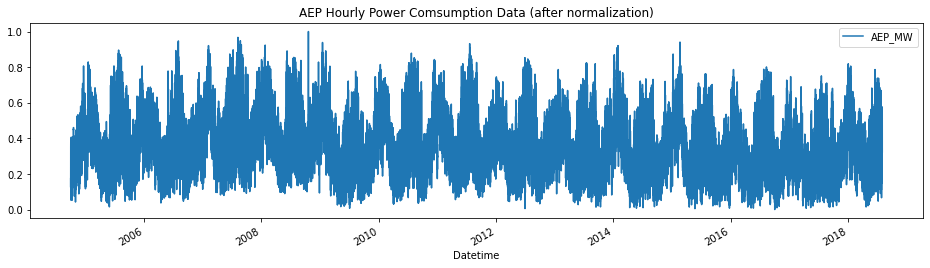

In [ ]:
# visualisasi data sesudah di normalisasi

df_norm.plot(figsize=(16,4), legend=True)
plt.title('AEP Hourly Power Comsumption Data (after normalization)')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


## Memeriksa min MAE < 10%

In [ ]:
# memeriksa min MAE

minMAE =(df['AEP_MW'].max() - df['AEP_MW'].min()) * 0.1
minMAE 

0.09999999999999999

## Persiapan untuk pelatihan model

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    # untuk test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    # untuk training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    # konversi ke np
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # mengubah data input model
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [ ]:
# membuat train dan test data

seq_len = 20 

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (11253, 20, 1)
y_test.shape =  (11253,)


## Melatih Model

In [ ]:
# membangun model

model = tf.keras.models.Sequential([
   tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(X_train.shape[1],1)),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.LSTM(60),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(30, activation='relu'),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(10, activation='relu'),
   tf.keras.layers.Dense(1)])

# menampilkan rangkuman model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 60)            14880     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [ ]:
# fungsi Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.03):
      print('\nMAE mencapai target! MAE < 10%')
      self.model.stop_training = True

callbacks = myCallback()

menambahkan batasan mae pada callback agar dapat membuat plot yang lebih jelas.

In [ ]:
# mengcompile model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])

# melatih model dnegan fit()
h = model.fit(X_train, y_train,
              epochs = 50,
              validation_split=0.2, # validasi 20%
              batch_size=256,
              callbacks=[callbacks])

Epoch 1/50
344/344 [==============================] - 5s 9ms/step - loss: 0.0078 - mae: 0.0932 - val_loss: 0.0020 - val_mae: 0.0495
Epoch 2/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0026 - mae: 0.0548 - val_loss: 9.9370e-04 - val_mae: 0.0345
Epoch 3/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0020 - mae: 0.0468 - val_loss: 0.0011 - val_mae: 0.0360
Epoch 4/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0017 - mae: 0.0425 - val_loss: 9.6784e-04 - val_mae: 0.0330
Epoch 5/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0015 - mae: 0.0399 - val_loss: 0.0010 - val_mae: 0.0326
Epoch 6/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0014 - mae: 0.0385 - val_loss: 0.0010 - val_mae: 0.0324
Epoch 7/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0372 - val_loss: 0.0013 - val_mae: 0.0365
Epoch 8/50
344/344 [==============================] - 3s 7ms/step - 

## Membuat Plot

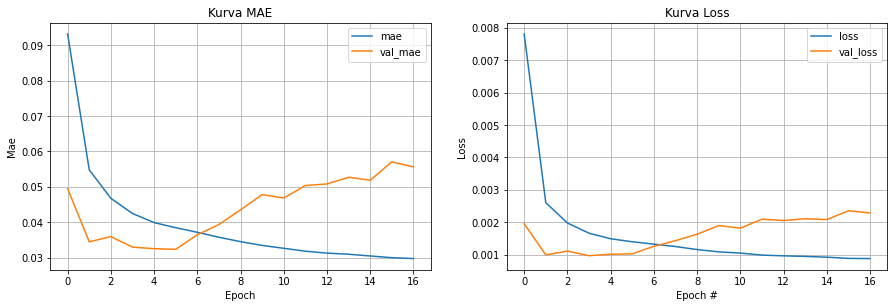

In [ ]:
# menampilkan kurva hasil pelatihan

fig = plt.figure(figsize=(8, 5))
fig.set_figheight(10)
fig.set_figwidth(15)

acc = h.history['mae']
loss = h.history['loss']

val_acc = h.history['val_mae']
val_loss = h.history['val_loss']

plt.subplot(2, 2, 1)
plt.plot(acc, label='mae')
plt.plot(val_acc, label='val_mae')
plt.title('Kurva MAE')
plt.xlabel('Epoch')
plt.ylabel('Mae')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('Kurva Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.grid()